In [1]:
import torch
import math
from ksddescent import ksdd_lbfgs, ksdd_gradient
from ksddescent.contenders import svgd, mmd_lbfgs
import matplotlib.pyplot as plt
import numpy as np

Run KSD descent

In [2]:
def score(x):
    return -x / 0.3


def potential(x):
    return (x ** 2).sum(dim=1)


# seems to be the target
def sampler(n_points):
    return math.sqrt(0.3) * torch.randn(n_points, 2)


n_samples = 50
p = 2 # dimension

# inital samples
# x = 1.5 + torch.randn(n_samples, p) / 3
x = 0.25 + torch.randn(n_samples, p) / 3 # make closer

bw = 0.1
x_ksd, ksd_traj, _ = ksdd_lbfgs(x.clone(), score, bw=bw, store=True)

x_grad, grad_traj, _ = ksdd_gradient(x.clone(), score, 0.3, bw=bw, store=True)



In [3]:
epsilon = torch.randn(200, p) # random samples, used for reparameterization trick

# Define parameters for the Gaussian distribution
m = torch.tensor([0.0, 0.0])  # mean
L = torch.tensor([[0.5, 0.0], [0.1, 0.4]])  # lower triangular matrix for covariance

x = m + torch.matmul(L, epsilon.T).T # reparameterized samples

score_reparam = score(x)

print("Shape of the result:", score_reparam.shape)
print("First few values of the reparameterized score:")
print(score_reparam[:5])


Shape of the result: torch.Size([200, 2])
First few values of the reparameterized score:
tensor([[ 1.1491,  1.6833],
        [-1.8682, -1.2144],
        [-0.3956,  1.5890],
        [ 0.4300,  0.0060],
        [-2.3358, -2.8225]])


In [4]:
# mimic a torch function
m = torch.tensor(m, dtype=torch.float32, requires_grad=True)
L = torch.tensor(L, dtype=torch.float32, requires_grad=True)

epsilon = torch.randn(n_samples, p)
x = m + torch.matmul(L, epsilon.T).T
scores_x = score(x)


/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_39812/1968699959.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(m, dtype=torch.float32, requires_grad=True)
/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_39812/1968699959.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L, dtype=torch.float32, requires_grad=True)


In [5]:

# Check the shape of x
print("Shape of x:", x.shape)

# Optionally, you can also print the first few rows of x
print("First few rows of x:")
print(x[:5])


Shape of x: torch.Size([50, 2])
First few rows of x:
tensor([[-0.4085,  0.7478],
        [ 0.0366, -0.4171],
        [-0.6829, -0.2770],
        [ 0.2629,  0.2298],
        [ 0.4967,  0.2998]], grad_fn=<SliceBackward0>)


In [6]:
from ksddescent.kernels import (imq_kernel, gaussian_stein_kernel_single,
                      linear_stein_kernel)

In [7]:

kernel = 'gaussian'
if kernel == 'gaussian':
    stein_kernel = gaussian_stein_kernel_single(x, scores_x, bw)
elif kernel == 'imq':
    stein_kernel = imq_kernel(x, x, scores_x, scores_x, bw, beta=beta)
else:
    stein_kernel = linear_stein_kernel(x, x, scores_x, scores_x)

In [8]:
# Check the size of stein_kernel
print("Shape of stein_kernel:", stein_kernel.shape)

# Optionally, print a small subset of the kernel matrix
print("First 5x5 elements of stein_kernel:")
print(stein_kernel[:5, :5])


Shape of stein_kernel: torch.Size([50, 50])
First 5x5 elements of stein_kernel:
tensor([[28.0682, -0.0801, -0.4649, -2.0623, -0.7056],
        [-0.0801, 21.9482, -3.4489, -4.1625, -2.0698],
        [-0.4649, -3.4489, 26.0347, -0.4304, -0.0387],
        [-2.0623, -4.1625, -0.4304, 21.3548, 10.6021],
        [-0.7056, -2.0698, -0.0387, 10.6021, 23.7397]],
       grad_fn=<SliceBackward0>)


In [9]:
loss_list = [] # mimic the loss list

loss = stein_kernel.sum() / n_samples ** 2
loss.backward()
loss_list.append(loss.item())

### now do back prop / gradient descent to the parameters m, L, which are torch tensors

In [16]:
# mimic
verbose=True

step = 0.3

n = None

In [17]:
i = 0

In [18]:
if verbose and i % 100 == 0:
    print(i, loss.item())

# Perform gradient descent on m and L
with torch.no_grad():
    # Update m
    m -= step * m.grad
    
    # Update L
    L -= step * L.grad
    
    # Apply additional adjustments if needed
    if n is not None:
        m -= n
        L -= n

    # TODO: not clear how clamp should be applied here
    # # Clamp values if clamp range is specified
    # if clamp is not None:
    #     m.clamp_(clamp[0], clamp[1])
    #     L.clamp_(clamp[0], clamp[1])
    
    # Reset the gradients to zero for the next iteration
    m.grad.zero_()
    L.grad.zero_()


0 0.5850788354873657


In [20]:
print("m:", m)
print("L:", L)

m: tensor([-0.0357, -0.3346], requires_grad=True)
L: tensor([[ 0.9849, -0.3436],
        [-0.0779,  1.2969]], requires_grad=True)


In [ ]:
# Explanation of m and L in the context of Gaussian distribution

# m represents the mean vector of the Gaussian distribution
# In a multivariate Gaussian, m is a vector that defines the center of the distribution
# Each element of m corresponds to the mean of one dimension of the distribution

# L represents the lower triangular matrix of the Cholesky decomposition of the covariance matrix
# The covariance matrix Σ can be decomposed as Σ = L * L^T
# L is used instead of Σ directly because:
#   1. It ensures the covariance matrix remains positive definite
#   2. It reduces the number of parameters to optimize (L has n(n+1)/2 elements vs n^2 for Σ)
#   3. It allows for more numerically stable computations

# Together, m and L fully parameterize a multivariate Gaussian distribution
# This parameterization is often used in optimization tasks because:
#   - It guarantees a valid (positive definite) covariance matrix
#   - It's more efficient than working with the full covariance matrix

print("m (mean vector):", m)
print("L (Cholesky factor of covariance):", L)

# To get the full covariance matrix, you would compute:
cov = L @ L.T
print("Covariance matrix:", cov)

# The Gaussian distribution defined by these parameters would be:
# N(x | m, L * L^T)


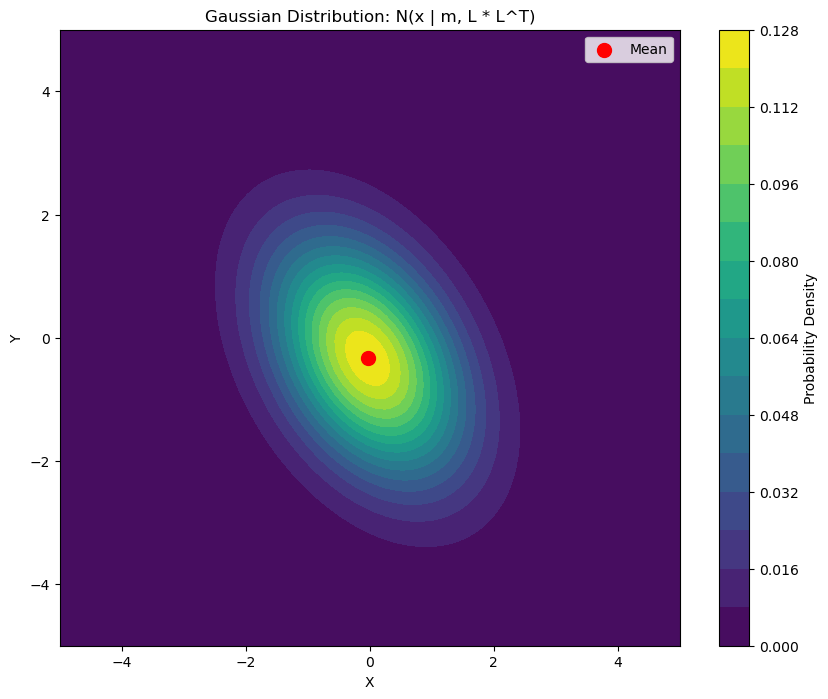

In [21]:
# Visualize the Gaussian distribution
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Prepare the grid points as a 2D tensor
grid = torch.tensor(np.column_stack([X.ravel(), Y.ravel()]), dtype=torch.float32)

# Compute the PDF of the Gaussian distribution
mean = m.detach().numpy()
cov = (L @ L.T).detach().numpy()
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = np.array([X[i, j], Y[i, j]])
        Z[i, j] = np.exp(-0.5 * (point - mean) @ np.linalg.inv(cov) @ (point - mean)) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))

# Plot the contours of the Gaussian distribution
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Probability Density')
plt.title('Gaussian Distribution: N(x | m, L * L^T)')
plt.xlabel('X')
plt.ylabel('Y')

# Plot the mean point
plt.scatter(mean[0], mean[1], color='red', s=100, label='Mean')
plt.legend()

plt.show()


In [ ]:
def ksdd_lbfgs_gaussian(x0, score, kernel='gaussian', bw=1.,
                        max_iter=10000, tol=1e-12, beta=.5,
                        store=False, verbose=False):
    '''Kernel Stein Discrepancy descent with L-BFGS for Gaussian parameters

    Perform Kernel Stein Discrepancy descent with L-BFGS on Gaussian parameters.
    L-BFGS is a fast and robust algorithm, that has no
    critical hyper-parameter.

    Parameters
    ----------
    x0 : torch.tensor, size n_samples x n_features
        initial positions

    score : callable
        function that computes the score

    kernel : 'gaussian' or 'imq'
        which kernel to choose

    max_iter : int
        max number of iters

    bw : float
        bandwidth of the stein kernel

    tol : float
        stopping criterion for L-BFGS

    store : bool
        whether to store the iterates

    verbose: bool
        whether to print the current loss

    Returns
    -------
    x: torch.tensor, size n_samples x n_features
        The final positions
    '''
    n_samples, p = x0.shape
    
    # Initialize mean and covariance
    m = torch.mean(x0, dim=0).numpy()
    S = torch.cov(x0.T)
    L = torch.linalg.cholesky(S).numpy()
    
    params = np.concatenate([m, L.ravel()])

    if store:
        class callback_store():
            def __init__(self):
                self.mem = []
                self.timer = []

            def __call__(self, params):
                self.mem.append(np.copy(params))
                self.timer.append(len(self.mem))

            def get_output(self):
                return self.mem, self.timer
        callback = callback_store()
    else:
        callback = None

    def loss_and_grad(params):
        m, L = params[:p], params[p:].reshape(p, p)
        m = torch.tensor(m, dtype=torch.float32, requires_grad=True)
        L = torch.tensor(L, dtype=torch.float32, requires_grad=True)
        
        epsilon = torch.randn(n_samples, p)
        x = m + torch.matmul(L, epsilon.T).T
        scores_x = score(x)
        
        if kernel == 'gaussian':
            stein_kernel = gaussian_stein_kernel_single(x, scores_x, bw)
        elif kernel == 'imq':
            stein_kernel = imq_kernel(x, x, scores_x, scores_x, bw, beta=beta)
        else:
            stein_kernel = linear_stein_kernel(x, x, scores_x, scores_x)
        
        loss = stein_kernel.sum()
        loss.backward()
        
        grad_m = m.grad.numpy()
        grad_L = L.grad.numpy()
        grad = np.concatenate([grad_m, grad_L.ravel()])
        
        return loss.item(), np.float64(grad)

    params, f, d = fmin_l_bfgs_b(loss_and_grad, params, maxiter=max_iter,
                                 factr=tol, epsilon=1e-12, pgtol=1e-10,
                                 callback=callback)
    if verbose:
        print('Took %d iterations, loss = %.2e' % (d['nit'], f))
    
    m_final, L_final = params[:p], params[p:].reshape(p, p)
    m_final = torch.tensor(m_final, dtype=torch.float32)
    L_final = torch.tensor(L_final, dtype=torch.float32)
    
    epsilon = torch.randn(n_samples, p)
    x_final = m_final + torch.matmul(L_final, epsilon.T).T
    
    if store:
        storage, timer = callback.get_output()
        return x_final, storage, timer, (m_final, L_final)
    return x_final, (m_final, L_final)

In [ ]:
# Call the ksdd_lbfgs_gaussian function for updating Gaussians
x_ksd_gaussian, ksd_gaussian_traj, (m_final, L_final) = ksdd_lbfgs_gaussian(
    x.clone(),
    score,
    kernel='gaussian',
    bw=bw,
    max_iter=10000,
    tol=1e-12,
    store=True,
    verbose=True
)

# Print the results
print("Final mean:", m_final)
print("Final L (Cholesky of covariance):", L_final)

# Plot the results
plt.figure(figsize=(4, 4))
plt.scatter(x[:, 0], x[:, 1], s=3, color="green", label="Initial")
plt.scatter(x_ksd_gaussian[:, 0], x_ksd_gaussian[:, 1], s=3, color="red", label="KSD Gaussian")
plt.legend()
plt.title("KSD L-BFGS with Gaussian Reparameterization")
plt.show()

# Compare with the original KSD L-BFGS results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 1], s=3, color="green", label="Initial")
plt.scatter(x_ksd[:, 0], x_ksd[:, 1], s=3, color="blue", label="KSD L-BFGS")
plt.legend()
plt.title("Original KSD L-BFGS")

plt.subplot(1, 2, 2)
plt.scatter(x[:, 0], x[:, 1], s=3, color="green", label="Initial")
plt.scatter(x_ksd_gaussian[:, 0], x_ksd_gaussian[:, 1], s=3, color="red", label="KSD Gaussian")
plt.legend()
plt.title("KSD L-BFGS with Gaussian Reparameterization")

plt.tight_layout()
plt.show()


In [ ]:
# Check the dimensions of x and the output of score(x)
print("Input x shape:", x.shape)
score_output = score(x)
print("Score output shape:", score_output.shape)

# Optionally, you can also print a few values to verify the content
print("\nFirst few values of x:")
print(x[:5])
print("\nFirst few values of score(x):")
print(score_output[:5])

In [ ]:
# Define the new KSD L-BFGS algorithm with Gaussian reparameterization
def ksdd_lbfgs_gaussian(x0, score, kernel='gaussian', bw=1.,
                        max_iter=10000, tol=1e-12, beta=.5,
                        store=False, verbose=False):
    n_samples, p = x0.shape
    
    # Initialize mean and covariance
    m = torch.mean(x0, dim=0)
    S = torch.cov(x0.T)
    L = torch.linalg.cholesky(S)
    
    def reparameterized_score(params):
        m, L = params[:p], params[p:].reshape(p, p)
        epsilon = torch.randn(n_samples, p)
        x = m + torch.matmul(L, epsilon.T).T
        return score(x)
    
    params = torch.cat([m.flatten(), L.flatten()])
    
    ### FIXME: Something is wrong with this line 
    # mimic the particle inference case
    result = ksdd_lbfgs(params.unsqueeze(0), reparameterized_score, kernel=kernel, bw=bw,
                        max_iter=max_iter, tol=tol, beta=beta,
                        store=store, verbose=verbose)
    
    if store:
        output, storage, timer = result
        m_final, L_final = output[0, :p], output[0, p:].reshape(p, p)
        epsilon = torch.randn(n_samples, p)
        x_final = m_final + torch.matmul(L_final, epsilon.T).T
        
        def reconstruct(params):
            m, L = params[0, :p], params[0, p:].reshape(p, p)
            epsilon = torch.randn(n_samples, p)
            return m + torch.matmul(L, epsilon.T).T
        
        storage = [reconstruct(s.unsqueeze(0)) for s in storage]
        return x_final, storage, (m_final, L_final)
    else:
        m_final, L_final = result[0, :p], result[0, p:].reshape(p, p)
        epsilon = torch.randn(n_samples, p)
        x_final = m_final + torch.matmul(L_final, epsilon.T).T
        return x_final

# Run the new algorithm
x_ksd_gaussian, ksd_gaussian_traj, (m_final, L_final) = ksdd_lbfgs_gaussian(x.clone(), score, bw=bw, store=True)


In [ ]:

# Plot the trajectory of Gaussian measures
plt.figure(figsize=(6, 6))
traj = np.array([x.detach().numpy() for x in ksd_gaussian_traj])
plt.plot(traj[:, :, 0], traj[:, :, 1], c="k", alpha=0.2, linewidth=0.5)
plt.scatter(x[:, 0], x[:, 1], s=3, color="green", zorder=1, label="Initial")
plt.scatter(x_ksd_gaussian[:, 0], x_ksd_gaussian[:, 1], s=3, c="blue", zorder=10, label="Final")

# Plot contours for initial, intermediate, and final Gaussian measures
colors = ['green', 'orange', 'blue']
alphas = [0.3, 0.5, 0.7]
for i, step in enumerate([0, len(ksd_gaussian_traj) // 2, -1]):
    m = ksd_gaussian_traj[step].mean(dim=0).detach().numpy()
    S = torch.cov(ksd_gaussian_traj[step].T).detach().numpy()
    
    x_, y_ = np.mgrid[-3:3:.01, -3:3:.01]
    pos = np.dstack((x_, y_))
    rv = multivariate_normal(m, S)
    plt.contour(x_, y_, rv.pdf(pos), levels=5, colors=colors[i], alpha=alphas[i])

plt.legend()
plt.title("KSD L-BFGS with Gaussian Reparameterization")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Add the new results to the comparison
x_ksd_gaussian_final = x_ksd_gaussian.detach()
labels.append("KSD Gaussian")
methods.append("ksd_gaussian")
colors.append("cyan")



In [ ]:
# run the other algorithms

x_svgd, svgd_traj, _ = svgd(
    x.clone(), score, 0.5, bw=bw, store=True, verbose=True
)

x_mmd, mmd_traj, _ = mmd_lbfgs(
    x.clone(), sampler(100 * n_samples), bw=bw, store=True
)

In [ ]:
# plot the results

labels = ["KSD L-BFGS", "KSD Grad", "SVGD", "MMD"]
methods = ["bfgs", "grad", "svgd", "mmd"]
colors = ["blue", "purple", "orange", "red"]
for x_final, traj, label, color, method in zip(
    [x_ksd, x_grad, x_svgd, x_mmd],
    [ksd_traj, grad_traj, svgd_traj, mmd_traj],
    labels,
    colors,
    methods,
):
    plt.figure(figsize=(2, 2))
    traj = np.array([x.detach().numpy() for x in traj])
    if method == "mmd":
        alpha = 0.2
    else:
        alpha = 0.2
    plt.plot(traj[:, :, 0], traj[:, :, 1], c="k", alpha=alpha, linewidth=0.5)
    s = 3
    plt.scatter(x[:, 0], x[:, 1], s=s, color="green", zorder=1)

    x_final = x_final.detach()
    plt.scatter(
        x_final[:, 0], x_final[:, 1], label=label, s=s, c=color, zorder=10
    )
    plt.legend()

    x_ = np.linspace(-1.2, 3)
    y_ = np.linspace(-1.2, 3)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    Z = potential(XX).reshape(X.shape).detach().numpy()

    plt.contour(X, Y, Z, levels=10, colors="k")
    plt.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        right=False,
        labelleft=False,
    )
    plt.xlim(min(x_), max(x_))
    plt.ylim(min(y_), max(y_))
plt.show()

In [ ]:
# Now construct a new algorithm that is basically the KSD L-BFGS,
# but the underlying measure 
# $\mu$ is Gaussian, we can employ the reparametrization trick to enable direct differentiation with respect to the mean and covariance parameters. Let $\mu = \mathcal{N}(m, \Sigma)$, and express $x \sim \mu$ as $x = m + L\epsilon$, where $L$ is the Cholesky decomposition of $\Sigma$ (i.e., $LL^\top = \Sigma$) and $\epsilon \sim \mathcal{N}(0, I)$.